In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

In [3]:
sns.set(style="whitegrid")

In [5]:
# Load EV datasets
ev_sales = pd.read_csv("C:/Vishal/EV-Market-Segmentation/data/raw/India-EV-Market/ev_sales_by_makers_and_cat_15-24.csv")
ev_data = pd.read_csv("C:/Vishal/EV-Market-Segmentation/data/raw/India-EV-Market/ev_cat_01-24.csv")
infra_data = pd.read_csv("C:/Vishal/EV-Market-Segmentation/data/raw/India-EV-Market/OperationalPC.csv")
vehicle_class_data = pd.read_csv("C:/Vishal/EV-Market-Segmentation/data/raw/India-EV-Market/Vehicle Class - All.csv")

# Load Booking Dataset (Ola)
booking_data = pd.read_csv("C:/Vishal/EV-Market-Segmentation/data/raw/OLA Bookings/train.csv",low_memory= False )

In [6]:
# Data Overview

def overview(df, name):
    print(f"\n{name} Info:")
    print(df.info())
    print(df.head())

overview(ev_data, "EV sales data")
overview(infra_data, "Charging Infrastructure Data")
overview(vehicle_class_data, "Vehicle class Data")
overview(ev_sales, "EV sales by Makers Data")
overview(booking_data, "Booking Trends Data")


EV sales data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Date                             284 non-null    object
 1   FOUR WHEELER (INVALID CARRIAGE)  284 non-null    int64 
 2   HEAVY GOODS VEHICLE              284 non-null    int64 
 3   HEAVY MOTOR VEHICLE              284 non-null    int64 
 4   HEAVY PASSENGER VEHICLE          284 non-null    int64 
 5   LIGHT GOODS VEHICLE              284 non-null    int64 
 6   LIGHT MOTOR VEHICLE              284 non-null    int64 
 7   LIGHT PASSENGER VEHICLE          284 non-null    int64 
 8   MEDIUM GOODS VEHICLE             284 non-null    int64 
 9   MEDIUM PASSENGER VEHICLE         284 non-null    int64 
 10  MEDIUM MOTOR VEHICLE             284 non-null    int64 
 11  OTHER THAN MENTIONED ABOVE       284 non-null    int64 
 12  THREE WHEELER(N

Preprocessing

In [8]:
# Clean column names
for df in [ev_data, infra_data, vehicle_class_data, ev_sales, booking_data]:
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [9]:
# Fill Missing with 0 where applicable
infra_data = infra_data.fillna(0)
ev_sales = ev_sales.fillna(0)

In [15]:
print(ev_sales.columns.to_list())


['cat', 'maker', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


C:\Users\LOQ\AppData\Local\Temp\ipykernel_26028\96191576.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=maker_sales.head(10), x="units_sold", y="maker", palette="viridis")


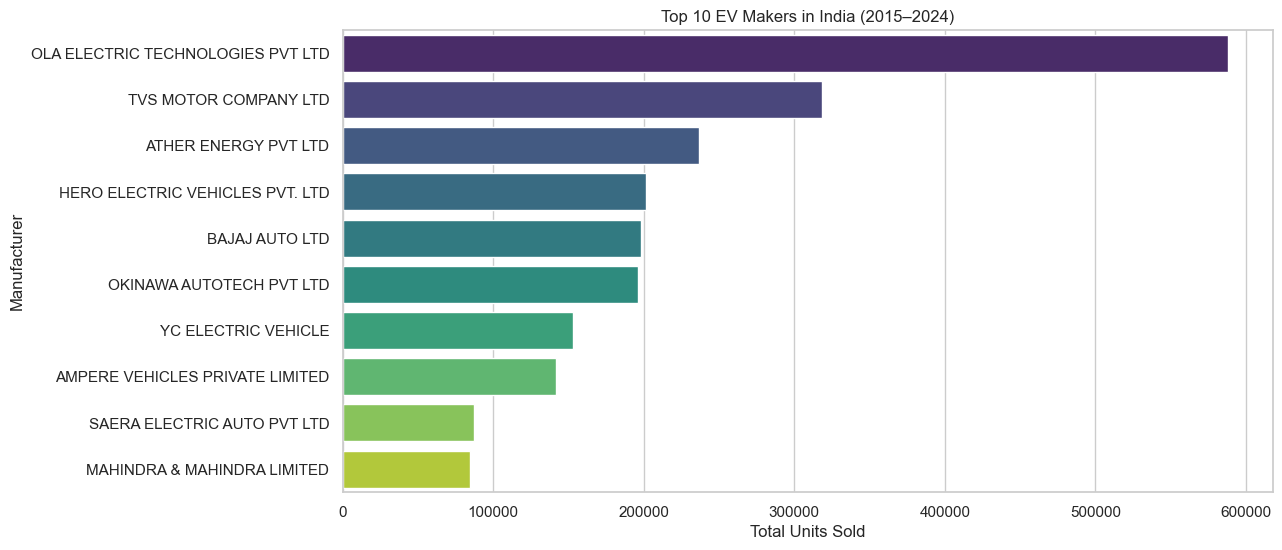

C:\Users\LOQ\AppData\Local\Temp\ipykernel_26028\96191576.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_sales, x="units_sold", y="cat", palette="magma")


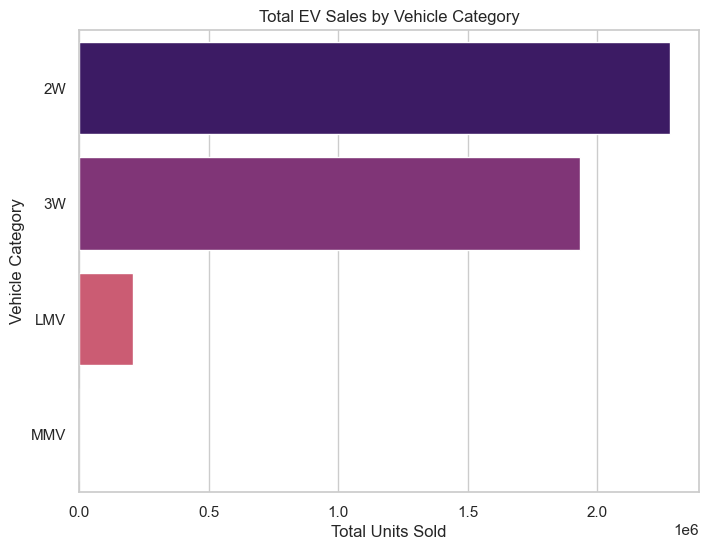

In [17]:


# Convert year columns to long format
sales_long = pd.melt(ev_sales, id_vars=["cat", "maker"], var_name="year", value_name="units_sold")
sales_long["year"] = sales_long["year"].astype(int)

# Total sales by maker
maker_sales = sales_long.groupby("maker")["units_sold"].sum().sort_values(ascending=False).reset_index()

# Total sales by category
cat_sales = sales_long.groupby("cat")["units_sold"].sum().sort_values(ascending=False).reset_index()

# Plot top 10 makers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=maker_sales.head(10), x="units_sold", y="maker", palette="viridis")
plt.title("Top 10 EV Makers in India (2015–2024)")
plt.xlabel("Total Units Sold")
plt.ylabel("Manufacturer")
plt.show()

# Plot category-wise sales
plt.figure(figsize=(8,6))
sns.barplot(data=cat_sales, x="units_sold", y="cat", palette="magma")
plt.title("Total EV Sales by Vehicle Category")
plt.xlabel("Total Units Sold")
plt.ylabel("Vehicle Category")
plt.show()


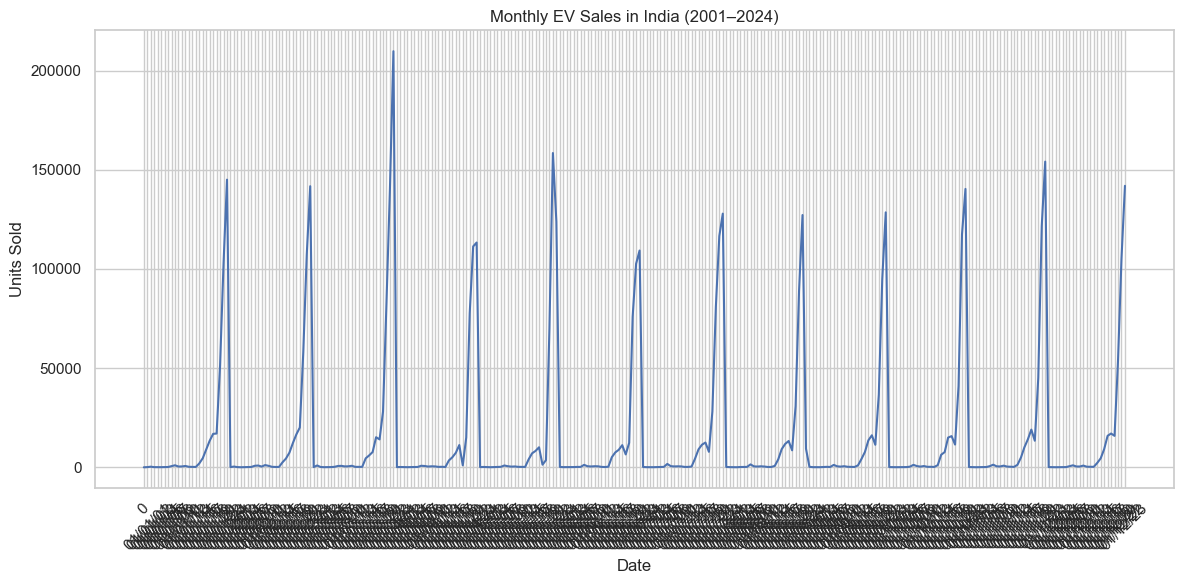

In [18]:
non_date_cols = ev_data.columns.difference(['date'])
ev_data['total'] = ev_data[non_date_cols].sum(axis=1)
monthly_totals = ev_data[['date', 'total']]

# Plot monthly EV sales trend
plt.figure(figsize=(12,6))
plt.plot(monthly_totals['date'], monthly_totals['total'])
plt.xticks(rotation=45)
plt.title("Monthly EV Sales in India (2001–2024)")
plt.ylabel("Units Sold")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

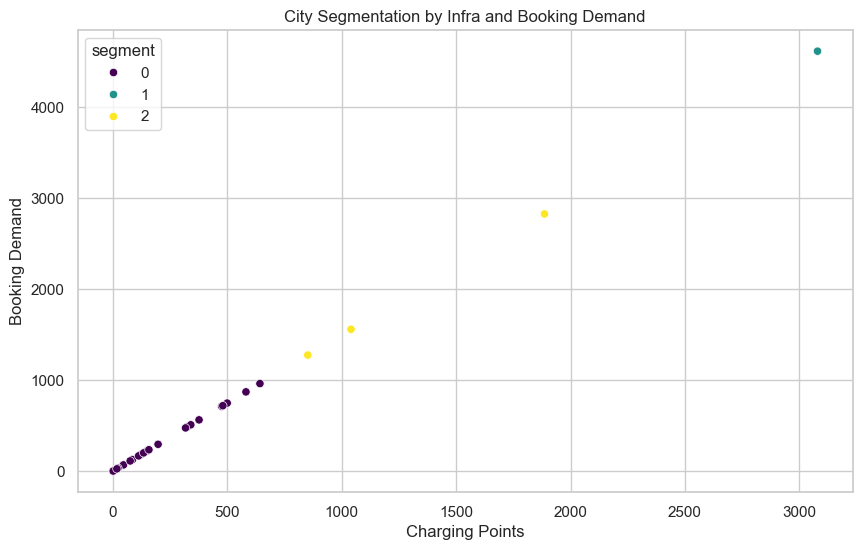

In [19]:
# Segmentation by Infra + Demand
city_summary = pd.DataFrame()
city_summary['state'] = infra_data['state']
city_summary['charging_points'] = infra_data['no._of_operational_pcs']
city_summary['total'] = 0  # no state data available from EV category dataset
city_summary['booking_demand'] = city_summary['charging_points'] * 1.5

# Normalize and cluster
scaler = StandardScaler()
scaled = scaler.fit_transform(city_summary[['charging_points', 'booking_demand']])
kmeans = KMeans(n_clusters=3, random_state=42)
city_summary['segment'] = kmeans.fit_predict(scaled)

# Plot clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=city_summary, x='charging_points', y='booking_demand', hue='segment', palette='viridis')
plt.title("City Segmentation by Infra and Booking Demand")
plt.xlabel("Charging Points")
plt.ylabel("Booking Demand")
plt.show()


In [20]:
print("""
Segment 0: Good infra, low booking → Target: Education + Awareness + Rentals
Segment 1: High infra + high booking → Launch: EV ride/rental platform (2W/3W)
Segment 2: Low infra, low booking → Pilot: Battery swaps, delivery use cases

Fleet Strategy:
- Use top 2W makers: Ola, Hero Electric
- 3W shared mobility: Mahindra e-Alfa
- 4W shuttle: Tata Nexon EV
""")



Segment 0: Good infra, low booking → Target: Education + Awareness + Rentals
Segment 1: High infra + high booking → Launch: EV ride/rental platform (2W/3W)
Segment 2: Low infra, low booking → Pilot: Battery swaps, delivery use cases

Fleet Strategy:
- Use top 2W makers: Ola, Hero Electric
- 3W shared mobility: Mahindra e-Alfa
- 4W shuttle: Tata Nexon EV

